In [48]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import requests
import zipfile
from pathlib import Path
import os
import random
from PIL import Image
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision import datasets
import pathlib
from typing import Tuple, Dict, List
import subprocess
import sys
from tqdm.auto import tqdm
from timeit import default_timer as timer 
import pandas as pd
import torchvision

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# シード値を設定
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# データフォルダへのパスを設定
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

In [3]:
# 画像フォルダが存在しない場合は、ダウンロードして準備
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # ピザ、ステーキ、寿司のデータをダウンロード
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
    
    # ピザ、ステーキ、寿司のデータを zipfile で解凍
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data\pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
# データ ディレクトリに何が含まれているかを調べる
def walk_through_dir(dir_path):
    """
    dir_path を走査し、その内容を返します。
    引数:
    dir_path (str または pathlib.Path): 対象ディレクトリ

    戻り値:
    以下の内容を表示します:
    dir_path 内のサブディレクトリ数
    各サブディレクトリ内の画像（ファイル）数
    各サブディレクトリ名
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [5]:
# トレーニングとテストのパスを設定
train_dir  =  image_path  /  "train" 
test_dir  =  image_path  /  "test"


# 画像を視覚化
# すべての画像パスを取得
image_path_list = list(image_path.glob("*/*/*.jpg"))

# ランダムな画像パスを取得
random_image_path = random.choice(image_path_list)

# パス名からイメージクラスを取得
image_class = random_image_path.parent.stem

# 画像を開く
img = Image.open(random_image_path)

# メタデータを出力
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img.show()

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


In [6]:

# 画像の変換を記述
data_transform = transforms.Compose([
    # 画像のサイズを 64x64 に変更
    transforms.Resize(size=(64, 64)),
    # 画像を水平方向にランダムに反転
    transforms.RandomHorizontalFlip(p=0.5), # p = 反転の確率、0.5 = 50%の確率
    #画像を torch.Tensor に変換
    transforms.ToTensor() # 0 から 255 までのすべてのピクセル値が 0.0 から 1.0 の間になるように変換される
])

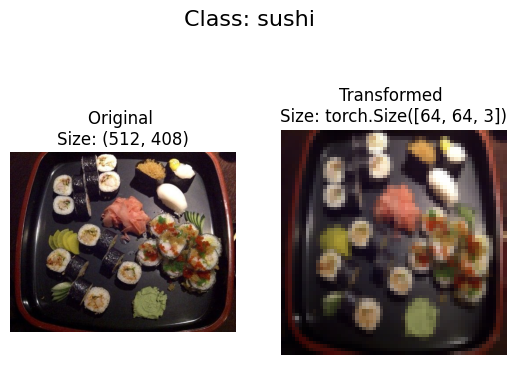

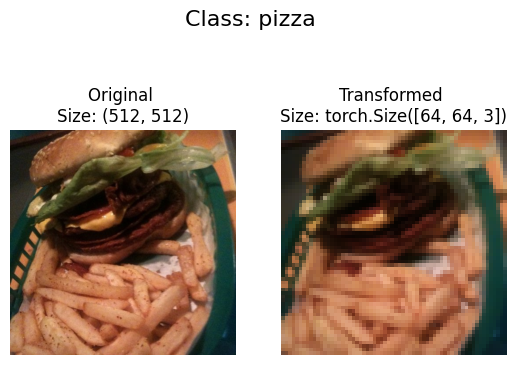

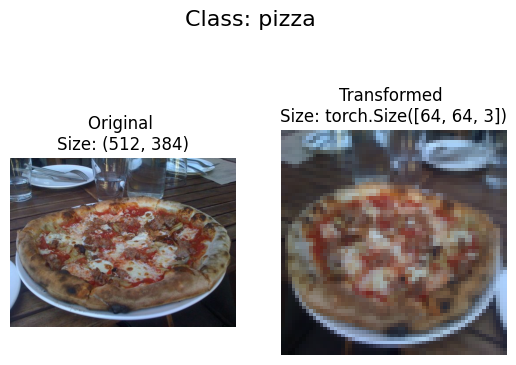

In [7]:

# さまざまな画像でそれを試す関数を記述
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """image_paths から一連のランダム画像をプロットします。

    image_paths から n 個の画像パスを開き、transform で変換して、並べてプロットします。

    引数:
    image_paths (リスト): 対象の画像パスのリスト。
    transform (PyTorch Transforms): 画像に適用する変換。
    n (整数、オプション): プロットする画像の数。デフォルトは 3。
    seed (整数、オプション): 乱数生成器の乱数シード。デフォルトは 42。
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            
            # 画像を変換してプロットする
            # 注: permute() は、matplotlib に合わせて画像の形状を変更します
            # (PyTorch のデフォルトは [C, H, W] ですが、Matplotlib は [H, W, C] です)
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)
plt.show()


Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902]

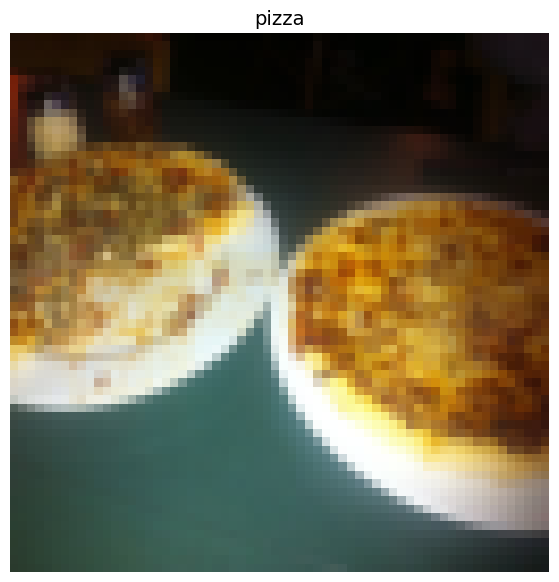

In [8]:
# ImageFolder を使用して画像データを読み込む
train_data = datasets.ImageFolder(root=train_dir, # 画像のターゲットフォルダ
                                transform=data_transform, # データ（画像）に対して実行する変換
                                target_transform=None) # ラベルに対して実行する変換（必要な場合）

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

# クラス名をリストとして取得する
class_names  =  train_data.classes

# クラス名を辞書として取得
class_dict  =  train_data.class_to_idx

img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

# 次元の順序を並べ替える
img_permute = img.permute(1, 2, 0)

# 異なるシェイプを出力する（並べ替え前と並べ替え後）
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

#　画像をプロット
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);
plt.show()

In [9]:

# トレーニング データセットとテスト データセットを DataLoader に変換
train_dataloader = DataLoader(dataset=train_data, 
                            batch_size=1, # バッチあたりのサンプル数
                            num_workers=1, # データのロードに使用するサブプロセスの数
                            shuffle=True) # データのシャッフル

test_dataloader = DataLoader(dataset=test_data, 
                            batch_size=1, 
                            num_workers=1, 
                            shuffle=False) # 通常はテストデータをシャッフルする必要はない

img, label = next(iter(train_dataloader))


In [10]:
# クラス名を取得するためのヘルパー関数の作成
# ターゲットディレクトリのパスを設定
target_directory = train_dir
print(f"Target directory: {target_directory}")

#ターゲットディレクトリからクラス名を取得
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

# ターゲット ディレクトリ内のクラスを検索する関数を作成
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """対象ディレクトリ内のクラスフォルダ名を検索します。

    対象ディレクトリは標準的な画像分類形式であると想定します。

    引数:
    directory (str): クラス名を読み込む対象ディレクトリ。

    戻り値:
    Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    例:
    find_classes("food_images/train")
        -> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    
    # 対象ディレクトリをスキャンしてクラス名を取得
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # クラス名が見つからない場合はエラー
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    
    # インデックスラベルの辞書を作成
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


Target directory: data\pizza_steak_sushi\train
Class names found: ['pizza', 'steak', 'sushi']


In [11]:
# ImageFolderを複製するためのカスタムデータセットを作成する
# カスタムデータセットクラスを書く (torch.utils.data.Dataset から継承) 

# torch.utils.data.Dataset のサブクラス
class ImageFolderCustom(Dataset):
    # targ_dirとtransform（オプション）パラメータで初期化
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # クラス属性を作成
        # すべての画像パスを取得
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # 変換を設定
        self.transform = transform
        # クラスと class_to_idx 属性を作成
        self.classes, self.class_to_idx = find_classes(targ_dir)
    
    # 画像を読み込む関数を作成
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # __len__() メソッドを上書き
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # __getitem__() メソッドを上書き
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx # return data, label (x, y)
        else:
            return img, class_idx # return data, label (x, y)


In [12]:

# トレーニングデータを拡張する
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# テストデータを拡張せず、形状を変更するだけ
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)

# カスタム データセットと ImageFolder データセットの等価性を確認
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)


True
True
True


In [13]:
# ランダム画像を表示する関数を作成
# データセットとクラス名のリストを取得
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                        classes: List[str] = None,
                        n: int = 10,
                        display_shape: bool = True,
                        seed: int = None):
    
    # n が大きすぎる場合は表示を調整
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # ランダムシードを設定
    if seed:
        random.seed(seed)
    
    # ランダムサンプルのインデックスを取得
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 8))
    
    # サンプルをループしてランダムサンプルを表示
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        
        # プロット用に画像テンソルの形状を調整する:
        targ_image_adjust = targ_image.permute(1, 2, 0)
    
        # 調整されたサンプルをプロット
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)


For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


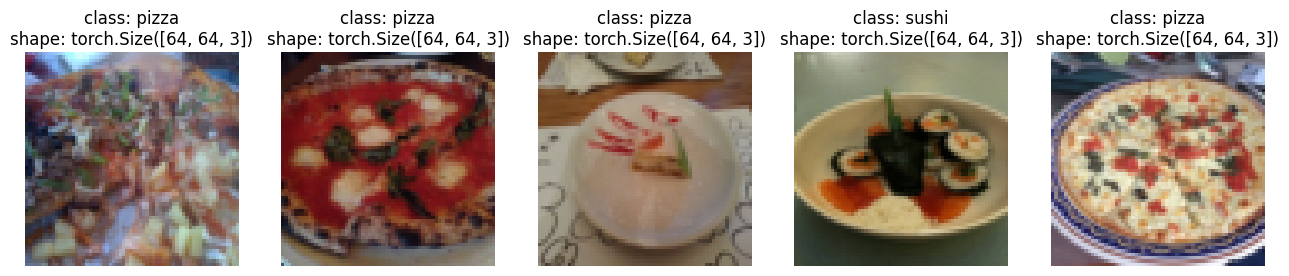

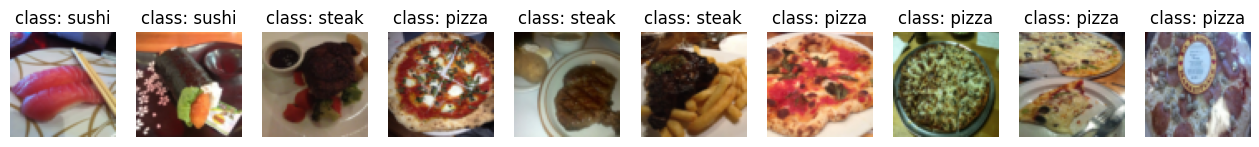

In [14]:
# ImageFolder で作成されたデータセットからランダムな画像を表示
display_random_images(train_data, n=5, classes=class_names, seed=None)

# ImageFolderCustom Dataset からランダムな画像を表示
display_random_images(train_data_custom, n=12, classes=class_names, seed=None)


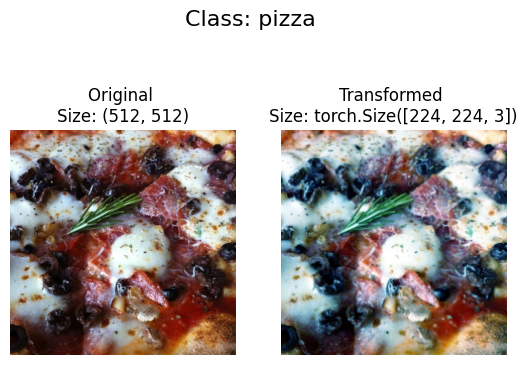

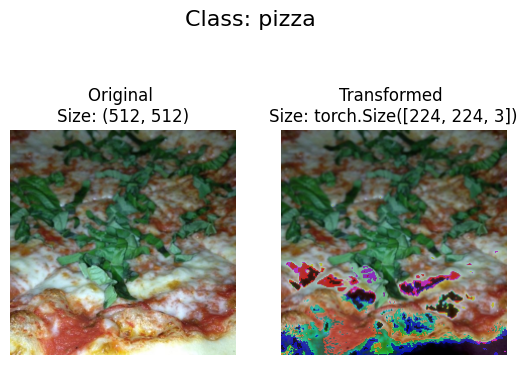

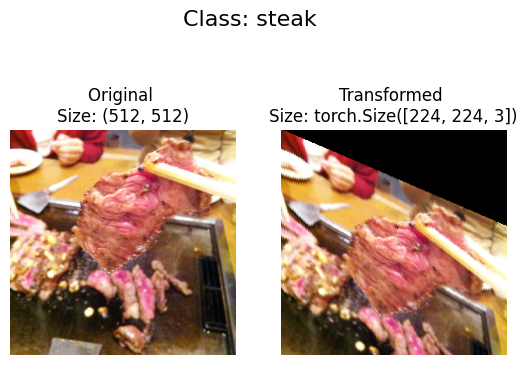

In [15]:

# トレーニングおよびテストのカスタム データセットを DataLoader に変換
train_dataloader_custom = DataLoader(dataset=train_data_custom, # カスタム作成したトレーニングデータセットを使用
                                    batch_size=1, # バッチあたりのサンプル数
                                    num_workers=0, # データロードに使用するサブプロセスの数
                                    shuffle=True) # データをシャッフルする

test_dataloader_custom = DataLoader(dataset=test_data_custom, # カスタム作成したテストデータセットを使用
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)

# カスタム DataLoader から画像とラベルを取得
img_custom, label_custom = next(iter(train_dataloader_custom))

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), 
    transforms.ToTensor() # 最後に ToTensor() を使って 0 から 1 の間の値をすべて取得
])

# テストデータに拡張を実行する必要はありません
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

# すべての画像パスを取得
image_path_list = list(image_path.glob("*/*/*.jpg"))

# ランダム画像をプロット
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)
plt.show()

In [16]:

# モデル0: データ拡張なしのTinyVGG
# モデル0の変換の作成とデータのロード
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [17]:

# torchvisionからデータを読み込んで変換する
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# データを DataLoader に変換する
# バッチサイズとワーカー数を設定
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")


Creating DataLoader's with batch size 32 and 16 workers.


In [18]:
# DataLoader の作成
train_dataloader_simple = DataLoader(train_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=True, 
                                    num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)


In [19]:
# TinyVGGモデルクラスの作成
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, # 画像を覆う正方形の大きさ
                    stride=1, 
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

model_0 = TinyVGG(input_shape=3, # カラーチャンネル数 (RGBの場合は3)
                hidden_units=10, 
                output_shape=len(train_data.classes)).to(device)

# 単一の画像でフォワードパスを試す（モデルをテストするため）
img_batch, label_batch = next(iter(train_dataloader_simple))


In [20]:
# バッチから単一の画像を取得し、その形状がモデルに適合するように画像をアンスクイーズ
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

Single image shape: torch.Size([1, 3, 64, 64])



In [21]:
# バッチから単一の画像を取得し、その形状がモデルに適合するように画像をアンスクイーズ
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

Single image shape: torch.Size([1, 3, 64, 64])



In [22]:
# torchinfo が存在しない場合にインストールし、インポート
try:
    import torchinfo
except ImportError:
    print("torchinfo が見つからないためインストールします...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torchinfo"])
    import torchinfo

# モデルの概要を表示
from torchinfo import summary

summary(model_0, input_size=(1, 3, 64, 64))  # テスト入力サイズを指定

torchinfo が見つからないためインストールします...


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [23]:
# トレーニングとテストのループ関数を作成
def train_step(model: torch.nn.Module, 
                dataloader: torch.utils.data.DataLoader, 
                loss_fn: torch.nn.Module, 
                optimizer: torch.optim.Optimizer):
    # モデルをトレーニングモードにする
    model.train()
    
    # テスト損失とテスト精度の値を設定する
    train_loss, train_acc = 0, 0
    
    # データローダーのデータバッチをループする
    for batch, (x, y) in enumerate(dataloader):
        # データをターゲットデバイスに送信
        x, y = x.to(device), y.to(device)

        # Forward pass
        y_pred = model(x)

        # 損失を計算して累積
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # ゼロ勾配オプティマイザー
        optimizer.zero_grad()

        # 逆方向損失
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # すべてのバッチにわたって精度メトリクスを計算して累積
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # バッチごとの平均損失と精度を取得するためにメトリクスを調整
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [24]:
def test_step(model: torch.nn.Module, 
            dataloader: torch.utils.data.DataLoader, 
            loss_fn: torch.nn.Module):
    # モデルを評価モードにする
    model.eval() 
    
    # テスト損失とテスト精度の値を設定する
    test_loss, test_acc = 0, 0
    
    # 推論コンテキストマネージャを有効にする
    with torch.inference_mode():
        # DataLoaderバッチをループする
        for batch, (x, y) in enumerate(dataloader):
            # データをターゲットデバイスに送信する
            x, y = x.to(device), y.to(device)
    
            # Forward pass
            test_pred_logits = model(x)

            # 損失を計算して累積する
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # 計算して精度を累積する
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # バッチごとの平均損失と精度を取得するためにメトリクスを調整する
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [25]:
# トレーニングおよびテストの手順に必要なさまざまなパラメーターを取得
def train(model: torch.nn.Module, 
        train_dataloader: torch.utils.data.DataLoader, 
        test_dataloader: torch.utils.data.DataLoader, 
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
        epochs: int = 5):
    
    # 空の結果辞書を作成する
        results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # トレーニング ステップとテスト ステップを、一定数のエポックにわたってループ
        for epoch in tqdm(range(epochs)):
            train_loss, train_acc = train_step(model=model,
                                                dataloader=train_dataloader,
                                                loss_fn=loss_fn,
                                                optimizer=optimizer)
            test_loss, test_acc = test_step(model=model,
                dataloader=test_dataloader,
                loss_fn=loss_fn)
            
            print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
                )
            
            # 5. 結果辞書を更新
            # すべてのデータが CPU に移動され、保存用に float に変換されていることを確認
            results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
            results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
            results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
            results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
        
        return results


In [31]:
# エポック数を設定
NUM_EPOCHS  =  5

#多分毎回設定する必要があると思う。最初のセルに設定したけどこれがなかったら変わってしまった。
torch.manual_seed(42) 
torch.cuda.manual_seed(42)
# TinyVGGのインスタンスを再作成
model_0 = TinyVGG(input_shape=3,
                hidden_units=10, 
                output_shape=len(train_data.classes)).to(device)

# 損失関数とオプティマイザーの設定
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# タイマーを開始
start_time = timer()

# model_0 をトレーニング
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# タイマーを終了し、かかった時間を出力
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1623 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1155 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0986 | train_acc: 0.4141 | test_loss: 1.1344 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0987 | train_acc: 0.2930 | test_loss: 1.1433 | test_acc: 0.1979
Total training time: 86.939 seconds


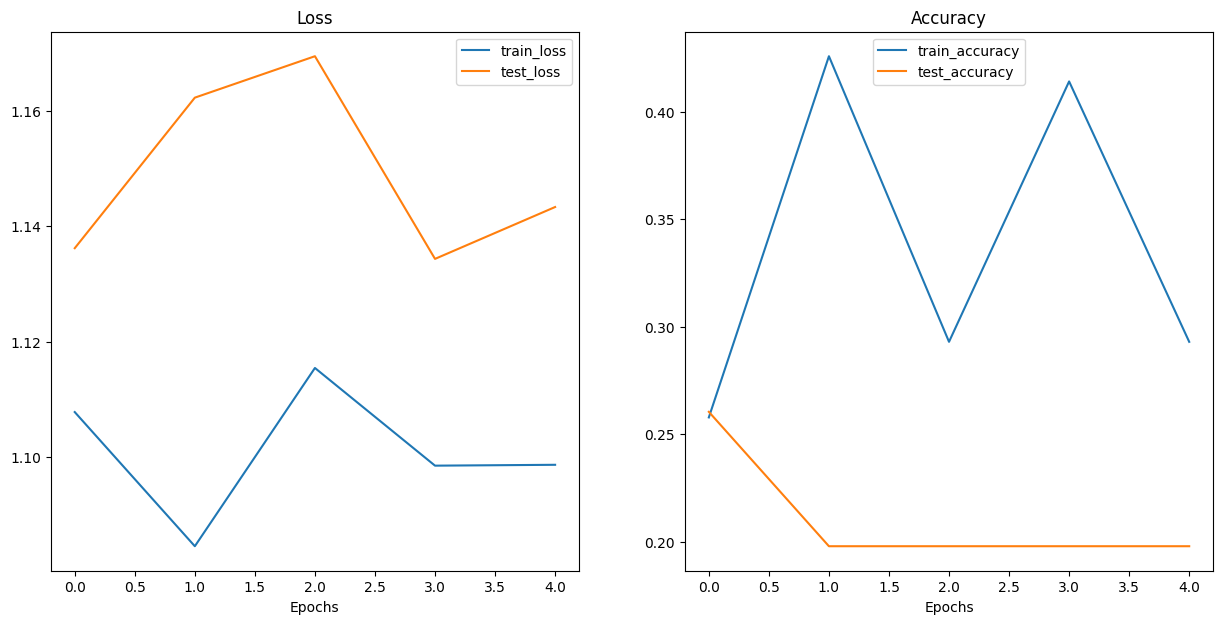

In [32]:
# モデル0の損失曲線をプロット
# model_0_resultsのキーを確認
model_0_results.keys()

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
            "train_acc": [...],
            "test_loss": [...],
            "test_acc": [...]}
    """
    
    # 結果辞書（トレーニングとテスト）の損失値を取得
    loss = results['train_loss']
    test_loss = results['test_loss']

    # 結果辞書（トレーニングとテスト）の精度値を取得します
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # エポックの数を計算する
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    plt.show()

plot_loss_curves(model_0_results)


In [33]:

# モデル1: データ拡張機能を備えたTinyVGG
# TrivialAugment を使用してトレーニング変換を作成
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# テスト変換を作成する（データ拡張なし）
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# 画像フォルダをデータセットに変換する
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

In [41]:
# model_1を作成し、ターゲットデバイスに送信
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [42]:
# エポック数を設定
NUM_EPOCHS = 5

torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# 損失関数とオプティマイザを設定
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# タイマーを開始
from timeit import default_timer as timer 
start_time = timer()

# model_1 を訓練
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# タイマーを停止し、かかった時間を出力
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1059 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0790 | train_acc: 0.4258 | test_loss: 1.1385 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0802 | train_acc: 0.4258 | test_loss: 1.1695 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1286 | train_acc: 0.3047 | test_loss: 1.1620 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0885 | train_acc: 0.4258 | test_loss: 1.1477 | test_acc: 0.2604
Total training time: 87.291 seconds


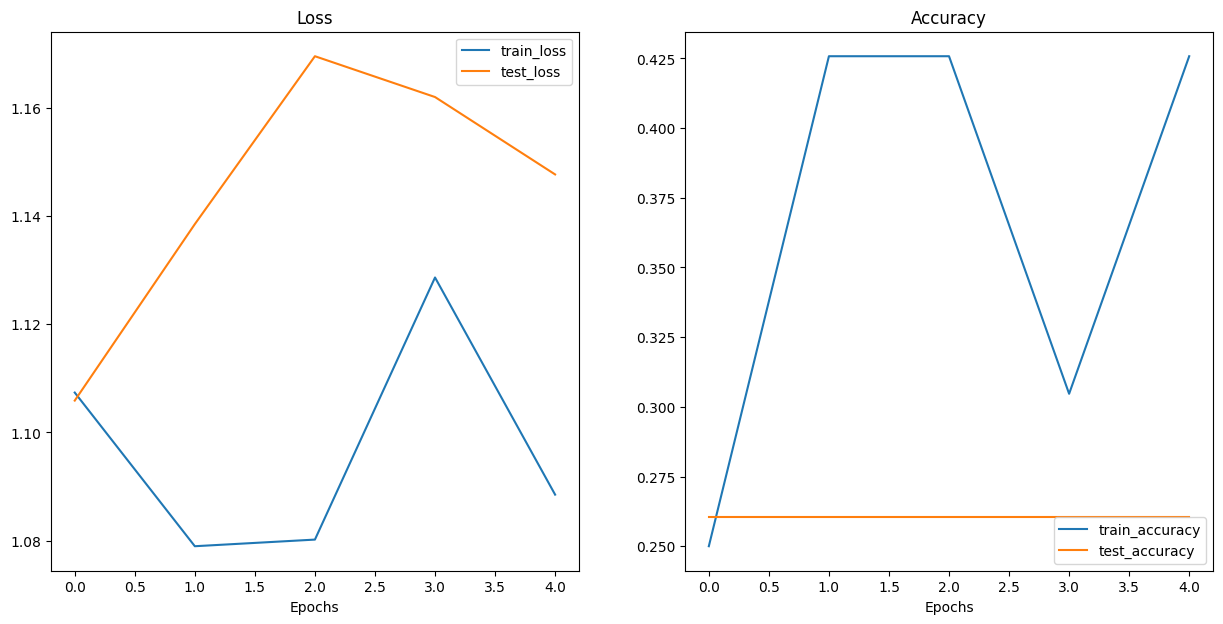

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [43]:
plot_loss_curves(model_1_results)

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

# プロットを設定
plt.figure(figsize=(15, 10))

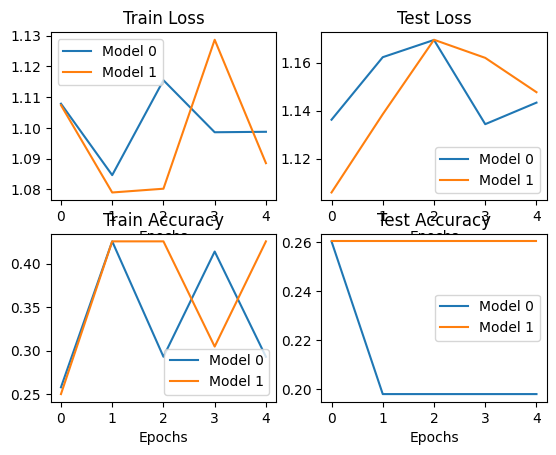

In [44]:
# エポック数を取得
epochs = range(len(model_0_df))

# 訓練損失をプロット
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# テスト損失をプロット
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# 訓練精度をプロット
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# テスト精度をプロット
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

plt.show()



In [49]:
# カスタム画像のパスを設定
custom_image_path = data_path / "04-pizza-dad.jpeg"

# 画像が存在しない場合はダウンロード
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # GitHubからダウンロードする場合は "raw" ファイルリンクを使う必要がある
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")
    
# カスタム画像を読み込む
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# 画像データを出力
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")


data\04-pizza-dad.jpeg already exists, skipping download.
Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom 

In [50]:
# カスタム画像を読み込み、テンソルの型を float32 に変換
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# 画像のピクセル値を [0, 1] に変換
custom_image = custom_image / 255. 

# 画像データを出力
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

In [51]:
# カスタム画像を読み込み、テンソルの型を float32 に変換
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# 画像のピクセル値を [0, 1] に変換
custom_image = custom_image / 255. 

# 画像データを出力
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

In [52]:
# 画像をリサイズするための変換パイプラインを作成
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# 画像を変換
custom_image_transformed = custom_image_transform(custom_image)

# 元の形状と新しい形状を出力
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")


Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [53]:
model_1.eval()
with torch.inference_mode():
    # 画像にバッチ次元を追加
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # 形状を出力
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # バッチ次元を追加した画像で予測
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))
    
# 予測ログitを出力
print(f"Prediction logits: {custom_image_pred}")

# ログit -> 予測確率に変換（多クラス分類の場合は torch.softmax() を使用）
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# 予測確率 -> ラベルに変換
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")


Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])
Prediction logits: tensor([[ 0.1184,  0.0273, -0.1456]], device='cuda:0')
Prediction probabilities: tensor([[0.3730, 0.3405, 0.2865]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


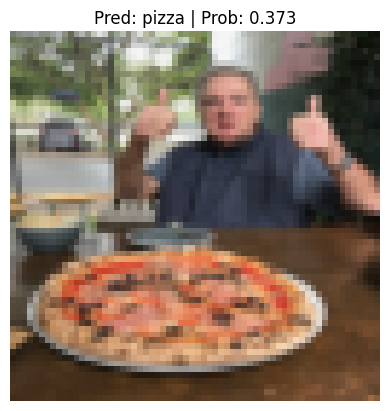

In [54]:
# 予測ラベルを取得
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]


def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """ターゲット画像で予測を行い、予測付きで画像をプロットする"""
    
    # 1. 画像を読み込み、テンソル値を float32 に変換
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. 画像のピクセル値を [0, 1] に変換
    target_image = target_image / 255. 
    
    # 3. 必要に応じて変換
    if transform:
        target_image = transform(target_image)
    
    # 4. モデルを対象デバイスに置く
    model.to(device)
    
    # 5. モデルを評価モードと推論モードに設定
    model.eval()
    with torch.inference_mode():
        # 画像にバッチ次元を追加
        target_image = target_image.unsqueeze(dim=0)
    
        # バッチ次元付きの画像で予測を実行し、デバイスに送る
        target_image_pred = model(target_image.to(device))
        
    # 6. ログit -> 予測確率に変換（多クラス分類）
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. 予測確率 -> ラベルに変換
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. 画像と予測・確率を一緒にプロット
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # matplotlib 用に次元を調整
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);


pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)
plt.show()